In [1]:
# Code illustrating import of gluon library
!sudo pip install mxnet
from __future__ import division

# Silence warnings
import warnings
warnings.filterwarnings('ignore')

import mxnet as mx
from mxnet import gluon, autograd, ndarray
import mxnet.ndarray as nd
import numpy as np

%matplotlib inline
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, zscore
from scipy import stats
from sklearn.model_selection import train_test_split
from collections import Counter

mx.random.seed(1)

    100% |################################| 11.4MB 100kB/s eta 0:00:01


Let's decide on some graphic options. Since these data sets have so many columns, it might be nice to see more of them than the default.

In [2]:
pd.set_option('max_columns', 110)
plt.style.use('ggplot')

Here we're reading in our data files and saving them as variables.

In [3]:
persons = pd.read_csv('data/person.csv')
accidents = pd.read_csv('data/accident.csv')
vehicles = pd.read_csv('data/vehicle.csv', encoding ='latin1')  # In case you get encoding errors

accidents.head()

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,NHS,RUR_URB,FUNC_SYS,RD_OWNER,ROUTE,TWAY_ID,TWAY_ID2,MILEPT,LATITUDE,LONGITUD,SP_JUR,HARM_EV,MAN_COLL,RELJCT1,RELJCT2,TYP_INT,WRK_ZONE,REL_ROAD,LGT_COND,WEATHER1,WEATHER2,WEATHER,SCH_BUS,RAIL,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR
0,1,10001,1,1,0,0,0,1,1,127,0,1,1,2015,5,2,40,0,1,3,1,3,SR-5,NaN,1754,33.878653,-87.325328,0,35,0,0,1,1,0,4,2,1,0,1,0,0000000,99,99,2,58,88,88,0,0,0,1,1
1,1,10002,1,1,0,0,0,1,1,83,0,1,1,2015,5,22,13,1,1,1,1,1,I-65,NaN,3604,34.910442,-86.908708,0,34,0,0,1,1,0,3,2,10,0,10,0,0000000,99,99,22,20,88,88,0,0,0,1,0
2,1,10003,1,1,0,0,0,2,2,11,0,1,1,2015,5,1,25,0,1,3,1,2,US-SR 6,NaN,1958,32.142006,-85.758456,0,42,0,0,1,1,0,4,2,1,0,1,0,0000000,99,99,1,45,99,99,0,0,0,1,1
3,1,10004,1,1,0,0,0,1,1,45,0,4,1,2015,1,0,57,0,1,4,1,3,SR-27,NaN,566,31.439814,-85.510300,0,53,0,0,1,1,0,4,2,10,0,10,0,0000000,99,99,1,15,88,88,0,0,0,1,1
4,1,10005,2,2,0,0,0,2,2,45,2050,7,1,2015,4,7,9,0,2,3,1,2,US-SR 53,HINTON WATERS AVE,308,31.319331,-85.515100,0,12,6,0,2,3,0,1,1,1,0,1,0,0000000,99,99,7,16,88,88,0,0,0,1,0


In [4]:
sub_features = [
# These features are basically all 0
    'PEDS',
    'PERNOTMVIT',
    'VE_TOTAL',
    'VE_FORMS',
    'PVH_INVL',
    'PERSONS',
    'PERMVIT',
    
    'COUNTY',
#     'CITY',
    'YEAR',
    'MONTH',
    'DAY',
    'DAY_WEEK',
    'HOUR',
    #Following 2 features are the same over different time horizons
#     'TWAY_ID',
#     'TWAY_ID2',
    #Following 2 features are the same over different time horizons
#     'CL_TWAY',
    'ROUTE',
    'TYP_INT',
    'LGT_COND',
    #Following 3 features are the same over different time horizons
    'WEATHER',
#     'WEATHER1',
#     'WEATHER2'
    'DRUNK_DR',
    
    # LABELS: We can choose which to prediect
    # Manner of Collision
#     'MAN_COLL',
    # First Harmul Event
    'HARM_EV'
]

df_accidents = accidents[sub_features]
df_accidents.head()

,PEDS,PERNOTMVIT,VE_TOTAL,VE_FORMS,PVH_INVL,PERSONS,PERMVIT,COUNTY,YEAR,MONTH,DAY,DAY_WEEK,HOUR,ROUTE,TYP_INT,LGT_COND,WEATHER,DRUNK_DR,HARM_EV
0,0,0,1,1,0,1,1,127,2015,1,1,5,2,3,1,2,1,1,35
1,0,0,1,1,0,1,1,83,2015,1,1,5,22,1,1,2,10,0,34
2,0,0,1,1,0,2,2,11,2015,1,1,5,1,2,1,2,1,1,42
3,0,0,1,1,0,1,1,45,2015,1,4,1,0,3,1,2,10,1,53
4,0,0,2,2,0,2,2,45,2015,1,7,4,7,2,3,1,1,0,12


Let's take a look at the co-variance of each feature pair.

In [5]:
sns.set(style="ticks")

# sns.pairplot(df_accidents)

Let's make sure that our labels are well-balanced.  We have two options for labels: Manner of Collision & Harm Event. 

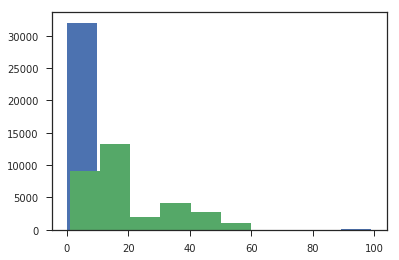

In [6]:
colission_labels = accidents['MAN_COLL'].values
harm_labels = accidents['HARM_EV'].values

plt.hist(colission_labels)
plt.hist(harm_labels)
plt.show()

It looks like Harm Event is better distributed, so let's begin by modelling that one.

Now that we have a sparse dataframe with features and labels (HARM_EV), we'll want to encode our categorical feautures.  Before we do that, let's decrease some of the sparsity by removing features that are missing more than half of their values.

In [7]:
# Some instances of 0 map to None, so we will remove columns that have an abundance of them
def trim_features(data_frame, ratio, label):
    print 'Begining columns:', len(data_frame.columns)
    # columns not to apply trim_features to
    leave_out = [label, 'DRUNK_DR', 'COUNTY', 'VE_TOTAL', 'PERNOTMVIT', 'PEDS']
    rows = data_frame.shape[0]
    for col in data_frame.columns:
        non_zeros = data_frame[col].astype(bool).sum(axis=0)
        # If there are more zeros than a given ratio, drop column
        if col in leave_out:
            break
        elif (non_zeros/rows)<ratio:
            data_frame.drop([col], axis=1, inplace=True)
    
    print 'Ending columns:', len(data_frame.columns)
    return data_frame
        
    
# Trim geographical columns
def trim_geo(data_frame, columns):
    for col in columns:
        data_frame[col] = data_frame[col].apply(lambda x: 0 if x>9995 else x)
    return data_frame
        

df_accidents_trimmed = trim_geo(df_accidents, ['COUNTY'])

df_accidents_trimmed.head() 

,PEDS,PERNOTMVIT,VE_TOTAL,VE_FORMS,PVH_INVL,PERSONS,PERMVIT,COUNTY,YEAR,MONTH,DAY,DAY_WEEK,HOUR,ROUTE,TYP_INT,LGT_COND,WEATHER,DRUNK_DR,HARM_EV
0,0,0,1,1,0,1,1,127,2015,1,1,5,2,3,1,2,1,1,35
1,0,0,1,1,0,1,1,83,2015,1,1,5,22,1,1,2,10,0,34
2,0,0,1,1,0,2,2,11,2015,1,1,5,1,2,1,2,1,1,42
3,0,0,1,1,0,1,1,45,2015,1,4,1,0,3,1,2,10,1,53
4,0,0,2,2,0,2,2,45,2015,1,7,4,7,2,3,1,1,0,12


Now that we have semi-dense data, let's one-hot encode our cateogrical features

In [8]:
sub_feature_classes = {
    'COUNTY': 1000,
    'YEAR': 100,
    'MONTH': 13,
    'DAY': 32,
    'DAY_WEEK': 8,
    'HOUR': 100,
    'ROUTE': 10,
    'TYP_INT': 100,
    'LGT_COND': 10,
    'WEATHER': 100,
    'DRUNK_DR': 4,
    
    'HARM_EV': 100
    # LABEL
#     'MAN_COLL': 100
}


# TODO: Encode with MXNet's One-Hot method
# One-hot encode all categorical features within a dataframe
def one_hot_encode_matrix(feature_matrix, label):
    features_one_hot = pd.DataFrame(index=feature_matrix.index)
    
    # First we want to encode the label
    y = pd.get_dummies(feature_matrix[label])
    y_one_hot = pd.DataFrame(y)
    
    # Now encode and concatenate input features
    for col in feature_matrix:
        # If categorical feature, one-hot encode
        if col in sub_feature_classes:
            df_temp = pd.get_dummies(feature_matrix[col])
        # If continuous feature, z-score
        # TODO: Only apply z-score to training set
        else:
            df_temp = feature_matrix[col].pipe(lambda x: (x - x.mean()) / x.std())
            
        features_one_hot = pd.concat([features_one_hot, df_temp], axis=1)
    
    features_one_hot.head()
    return features_one_hot, y_one_hot


X, y = one_hot_encode_matrix(df_accidents_trimmed, 'HARM_EV')
X.head()

,PEDS,PERNOTMVIT,VE_TOTAL,VE_FORMS,PVH_INVL,PERSONS,PERMVIT,1,3,5,6,7,9,11,12,13,14,15,16,17,19,20,21,23,25,27,29,31,33,35,36,37,39,41,43,45,47,49,50,51,53,55,57,59,60,61,63,65,67,69,71,73,75,77,78,...,0,1,2,3,1,2,3,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,23,24,25,26,30,31,32,33,34,35,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,54,57,58,59,72,73,99
0,-0.44679,-0.440708,-0.625114,-0.610760,-0.1325,-0.663425,-0.660447,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.44679,-0.440708,-0.625114,-0.610760,-0.1325,-0.663425,-0.660447,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.44679,-0.440708,-0.625114,-0.610760,-0.1325,-0.149339,-0.145118,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.44679,-0.440708,-0.625114,-0.610760,-0.1325,-0.663425,-0.660447,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,-0.44679,-0.440708,0.498833,0.561628,-0.1325,-0.149339,-0.145118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
y.head()

,1,2,3,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,23,24,25,26,30,31,32,33,34,35,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,54,57,58,59,72,73,99
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we create our train/test split:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1337)

#Convert train/test into iterable Gluon NDArrays
train_data_mx, test_data_mx, train_label_mx, test_label_mx = mx.nd.array(X_train), mx.nd.array(X_test), mx.nd.array(y_train), mx.nd.array(y_test)

print 'train_data_mx.shape:', train_data_mx.shape
print 'train_label_mx.shape:', train_label_mx.shape
print 'test_data_mx.shape:', test_data_mx.shape
print 'test_label_mx.shape:', test_label_mx.shape

train_data_mx.shape: (21551L, 467L)
train_label_mx.shape: (21551L, 51L)
test_data_mx.shape: (10615L, 467L)
test_label_mx.shape: (10615L, 51L)


Now let's define our sequential Gluon Model.

Gluon Reference: https://aws.amazon.com/blogs/ai/introducing-gluon-an-easy-to-use-programming-interface-for-flexible-deep-learning/

Thorough Tutorial: https://github.com/zackchase/mxnet-the-straight-dope

In [11]:
# Set context to use CPU
ctx = mx.cpu()

batch_size = 128
num_outputs = train_label_mx.shape[1]
lr = 0.1

# Encode train/test into Gluon readable format
train_data = mx.io.NDArrayIter(train_data_mx, train_label_mx, batch_size, shuffle=True)   
test_data = mx.io.NDArrayIter(test_data_mx, test_label_mx, batch_size, shuffle=False)

Network Architecture:

In [12]:
# First step is to initialize the model
net = gluon.nn.Sequential()
# Define model architecture
with net.name_scope():
#     net.add(gluon.nn.Dense(256, activation="relu"))
#     net.add(gluon.nn.Dropout(.2))
#     net.add(gluon.nn.Dense(128, activation="relu"))
#     net.add(gluon.nn.Dropout(.2))
#     net.add(gluon.nn.Dense(128, activation="relu"))
#     net.add(gluon.nn.Dropout(.2))
    net.add(gluon.nn.Dense(128, activation="relu"))
#     net.add(gluon.nn.Dropout(.2))
#     net.add(gluon.nn.Dense(64, activation="relu"))
#     net.add(gluon.nn.Dropout(.2))
    net.add(gluon.nn.Dense(num_outputs))

Training Features:

In [13]:
# We start with random values for all of the model’s parameters from a 
# normal distribution with a standard deviation of 0.05
net.collect_params().initialize(mx.init.Normal(sigma=0.05), ctx=ctx)

# We opt to use softmax cross entropy loss function
# sparse_label=False for one-hot labels
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

# Adam gradient optimization algorithm
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})

Trainin Process:

In [14]:
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat), axis=0, exclude=True)

def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    loss_avg = 0.
    for i, batch in enumerate(data_iterator):
        data = batch.data[0]
        label = batch.label[0]
        output = net(data)
        loss = softmax_cross_entropy(output, label)
#         loss = softmax_cross_entropy(output, label_one_hot)
        predictions = nd.argmax(output, axis=1)
        predictions = nd.one_hot(predictions, num_outputs)
#         print 'predictions', predictions, 'label', label
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return (numerator / denominator).asscalar(), loss_avg

In [15]:
def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'],fontsize=14)

In [16]:
loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []

epochs = 10
for e in range(epochs):
    # TODO: remove this when switching to mxnet.gluon.data.DataLoader implementation
    train_data = mx.io.NDArrayIter(train_data_mx, train_label_mx, batch_size, shuffle=True)   
    test_data = mx.io.NDArrayIter(test_data_mx, test_label_mx, batch_size, shuffle=False)
    print 'Training epoch', e+1
    for i, batch in enumerate(train_data):
        data = batch.data[0]
        label = batch.label[0]
        with autograd.record(): # Start recording the derivatives
            output = net(data) # the forward iteration
            loss = softmax_cross_entropy(output, label)
            epoch_loss = loss.asnumpy().sum()/batch_size
            print 'epoch_loss', epoch_loss
            loss.backward() # back-prop
        trainer.step(data.shape[0])
            
    train_data = mx.io.NDArrayIter(train_data_mx, train_label_mx, batch_size, shuffle=True)
    test_data = mx.io.NDArrayIter(test_data_mx, test_label_mx, batch_size, shuffle=True)
    
    # Accuracy metrics
    test_accuracy, test_loss = evaluate_accuracy(test_data, net)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)

    if True:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))

Training epoch 1
epoch_loss 3.87780237198
epoch_loss 3.97445130348
epoch_loss 3.55964708328
epoch_loss 2.34250164032
epoch_loss 1.60619831085
epoch_loss 1.9003098011
epoch_loss 2.68769431114
epoch_loss 1.84273922443
epoch_loss 1.60931038857
epoch_loss 1.54111528397
epoch_loss 1.41071772575
epoch_loss 1.21603775024
epoch_loss 1.25297117233
epoch_loss 1.26903295517
epoch_loss 0.986254930496
epoch_loss 1.1071318388
epoch_loss 0.669515728951
epoch_loss 0.675922453403
epoch_loss 0.690863549709
epoch_loss 4.17092895508
epoch_loss 0.872096717358
epoch_loss 1.25048136711
epoch_loss 0.96989095211
epoch_loss 0.897958755493
epoch_loss 1.18819129467
epoch_loss 1.14009571075
epoch_loss 0.465190649033
epoch_loss 0.972759306431
epoch_loss 0.806477546692
epoch_loss 0.876948297024
epoch_loss 0.435155928135
epoch_loss 0.589658677578
epoch_loss 0.441010773182
epoch_loss 0.516127824783
epoch_loss 0.452494561672
epoch_loss 0.629216790199
epoch_loss 0.484966576099
epoch_loss 1.42053318024
epoch_loss 0.71301

epoch_loss 1.03193342686
epoch_loss 0.119665332139
epoch_loss 0.119128294289
epoch_loss 0.146415397525
epoch_loss 0.18442428112
epoch_loss 0.232220202684
epoch_loss 0.114058852196
epoch_loss 0.23421677947
epoch_loss 0.0817024409771
epoch_loss 0.508437097073
epoch_loss 0.199412882328
epoch_loss 0.0521348342299
epoch_loss 0.211028516293
epoch_loss 0.119580104947
epoch_loss 0.0175498649478
epoch_loss 0.112136550248
epoch_loss 0.109089523554
epoch_loss 0.10538752377
epoch_loss 0.223242864013
epoch_loss 0.0818699300289
epoch_loss 0.0673906207085
epoch_loss 0.0640285536647
epoch_loss 0.210259735584
epoch_loss 0.206934735179
epoch_loss 0.0185964591801
epoch_loss 0.0322049483657
epoch_loss 0.176625609398
epoch_loss 0.147527530789
epoch_loss 0.138656809926
epoch_loss 0.0173681005836
epoch_loss 0.0250549372286
Completed epoch 2. Train Loss: 0.138748933908, Test Loss 0.171120761731, Train_acc 50.9696, Test_acc 50.9618
Training epoch 3
epoch_loss 0.110136605799
epoch_loss 0.0181471034884
epoch_los

epoch_loss 0.0689855366945
epoch_loss 0.0326000638306
epoch_loss 0.461802810431
epoch_loss 0.411836624146
epoch_loss 0.0734965801239
epoch_loss 0.00642395531759
epoch_loss 0.137741103768
epoch_loss 0.000141097290907
epoch_loss 0.045567702502
epoch_loss 0.00744649674743
epoch_loss 0.00262413639575
epoch_loss 0.121265396476
epoch_loss 0.13946390152
epoch_loss 0.101152271032
epoch_loss 0.0676589757204
epoch_loss 0.000119958996947
epoch_loss 0.0028088002
epoch_loss 0.0518819093704
epoch_loss 0.000231371057453
epoch_loss 0.0573410652578
epoch_loss 0.0828549265862
epoch_loss 0.192343711853
epoch_loss 0.0139113776386
epoch_loss 0.309212744236
epoch_loss 1.30492771859e-05
epoch_loss 0.0452395305037
epoch_loss 0.0180208366364
epoch_loss 0.00167741149198
epoch_loss 0.00629453919828
epoch_loss 0.00266698934138
epoch_loss 0.144782483578
epoch_loss 0.0106162121519
epoch_loss 0.0068742102012
epoch_loss 0.00349748576991
epoch_loss 0.0799012109637
epoch_loss 0.316950976849
epoch_loss 0.010783592239
ep

epoch_loss 0.0141928028315
epoch_loss 0.148102402687
epoch_loss 0.0249336287379
epoch_loss 0.00167207210325
epoch_loss 0.0608072727919
epoch_loss 0.278521299362
epoch_loss 0.0167423989624
epoch_loss 0.00687949452549
epoch_loss 3.75101408281e-05
epoch_loss 0.00174753810279
epoch_loss 0.131483897567
epoch_loss 0.0233993940055
epoch_loss 0.0229588598013
epoch_loss 0.0275834947824
epoch_loss 0.0241377688944
epoch_loss 0.0921269953251
epoch_loss 0.149692863226
epoch_loss 0.103709183633
epoch_loss 0.0480792075396
epoch_loss 0.105927154422
epoch_loss 0.124502889812
epoch_loss 0.0414450503886
epoch_loss 0.024167008698
epoch_loss 1.86264355051e-08
epoch_loss 6.8674207796e-06
epoch_loss 0.0165899656713
epoch_loss 7.00701930327e-05
epoch_loss 0.0351819545031
epoch_loss 0.173005744815
epoch_loss 0.0668819993734
epoch_loss 0.0479429326952
epoch_loss 0.08775806427
epoch_loss 0.0487589463592
epoch_loss 0.132811173797
epoch_loss 0.153036996722
epoch_loss 0.00115275161806
epoch_loss 0.109805636108
epoc

epoch_loss 0.357757031918
epoch_loss 0.0115752406418
epoch_loss 0.29025053978
epoch_loss 0.208666041493
epoch_loss 1.78407663043e-05
epoch_loss 6.53719234833e-06
epoch_loss 0.112222731113
epoch_loss 0.0251468457282
epoch_loss 6.06058029007e-06
epoch_loss 0.0
epoch_loss 0.200100556016
epoch_loss 0.183050841093
epoch_loss 0.217915594578
epoch_loss 0.0728509277105
epoch_loss 0.06786878407
epoch_loss 0.0769831836224
epoch_loss 0.115695714951
epoch_loss 0.466423153877
epoch_loss 0.0211748667061
epoch_loss 0.000964215607382
epoch_loss 0.0184211153537
epoch_loss 0.00411851843819
epoch_loss 1.22907197475
epoch_loss 0.0320484824479
epoch_loss 0.000414874608396
epoch_loss 0.0895390436053
epoch_loss 0.0410625934601
epoch_loss 0.0192656796426
epoch_loss 0.540534853935
epoch_loss 0.0116381794214
epoch_loss 0.518328666687
epoch_loss 0.210187211633
epoch_loss 0.00178477331065
epoch_loss 0.413041472435
epoch_loss 1.96506590555e-07
epoch_loss 0.273544639349
epoch_loss 1.30385107155e-08
epoch_loss 0.156

epoch_loss 0.394269883633
epoch_loss 0.0514619834721
epoch_loss 0.765417993069
epoch_loss 0.00271663814783
epoch_loss 0.0422511287034
epoch_loss 0.0705791860819
epoch_loss 0.376675903797
epoch_loss 1.02439939976
epoch_loss 0.150188162923
epoch_loss 0.108528576791
epoch_loss 0.267351090908
epoch_loss 6.72381647746e-05
epoch_loss 0.097598940134
epoch_loss 6.15977987763e-05
epoch_loss 0.00013338244753
epoch_loss 1.7788109119e-07
epoch_loss 0.0034835152328
epoch_loss 0.996995866299
epoch_loss 0.0247665103525
epoch_loss 0.0942092612386
epoch_loss 0.121172375977
Completed epoch 9. Train Loss: 0.258111136355, Test Loss 0.319116926928, Train_acc 50.9794, Test_acc 50.9733
Training epoch 10
epoch_loss 0.086521923542
epoch_loss 0.000342648418155
epoch_loss 0.205919414759
epoch_loss 0.119235560298
epoch_loss 0.0164983253926
epoch_loss 0.0429713763297
epoch_loss 0.464459568262
epoch_loss 0.000261244538706
epoch_loss 0.208864271641
epoch_loss 0.0239855200052
epoch_loss 0.468207806349
epoch_loss 0.18

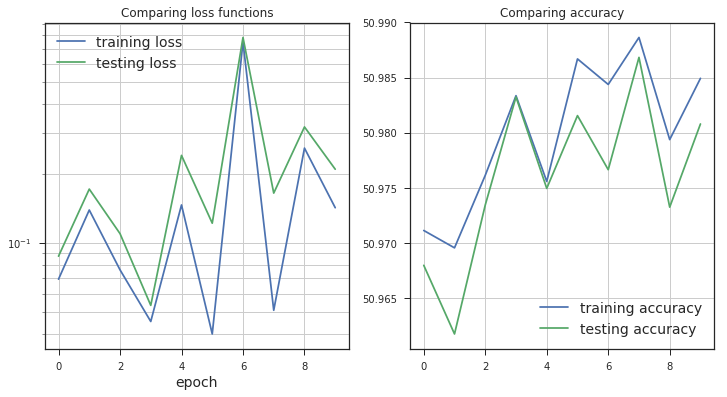

In [17]:
## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)

In [18]:
# Calculate and plot Confusion Matrix, ROC